In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"

# paths
MAIN_LONG = '../csv/wm_model_main.csv'
LINE_LONG = '../csv/wm_model_full_LME_lines.csv'
ABL_LONG  = '../csv/wm_model_ablation_bootstrap_r_summary.csv'
ABL_PAIRED_LONG = '../csv/wm_model_ablation_paired.csv'

# colors
colors = ['royalblue','indianred', ]

# output paths
OUTDIR = './figs'
os.makedirs(OUTDIR, exist_ok=True)

In [2]:
# Load data
main = pd.read_csv(MAIN_LONG)
abl  = pd.read_csv(ABL_LONG)
lines = pd.read_csv(LINE_LONG)
abl_paired = pd.read_csv(ABL_PAIRED_LONG)

# Basic cleanup
main['Group'] = main['Group'].astype(str)
abl['Group']  = abl['Group'].astype(str)

# Keep valid rows if present
if 'Valid' in main.columns:
    main = main[main['Valid'].astype(bool)].copy()
if 'Valid' in abl.columns:
    abl = abl[abl['Valid'].astype(bool)].copy()

# Set ordered categorical set size (nice for plotting)
set_order = [1, 2, 4]
main['SetSize'] = pd.Categorical(main['SetSize'], categories=set_order, ordered=True)


## 1) Predicted group-average WM precision

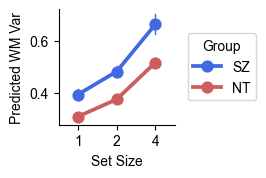

'./figs/model_predicted_wm.pdf'

In [3]:
f = plt.figure()
f.set_size_inches(1.5, 1.5)

sns.pointplot(data=main, x='SetSize', y='Predicted_invK', hue='Group', errorbar=('ci', 68), palette=colors, native_scale=False, err_kws={'linewidth': 1})

plt.xlabel('Set Size')
plt.ylabel('Predicted WM Var')
plt.legend(title='Group', bbox_to_anchor=(1.05, 0.5), loc='center left')
sns.despine()

outpath = os.path.join(OUTDIR, 'model_predicted_wm.pdf')
plt.savefig(outpath, dpi=300, transparent=True, bbox_inches='tight')
plt.show()
outpath

## 2) Empirical vs predicted scatter plots (FULL model)


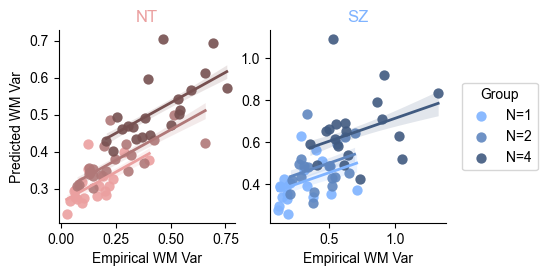

'./figs/model_predicted_empirical_scatter.pdf'

In [4]:
# colors
set_order = [1, 2, 4]
base_colors = {
    'NT': '#eba0a0',
    'SZ': '#7fb3ff' 
}

def color_gradient(base_color, dark_factor=0.65, n=3):
    rgb = np.array(mcolors.to_rgb(base_color))
    dark_rgb = rgb * dark_factor
    return [tuple(rgb * (1-t) + dark_rgb * t) for t in np.linspace(0, 1, n)]

pal = {
    'NT': dict(zip(set_order, color_gradient(base_colors['NT'], dark_factor=0.5, n=len(set_order)))),
    'SZ': dict(zip(set_order, color_gradient(base_colors['SZ'], dark_factor=0.5, n=len(set_order))))
}

# plot
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))  

for ax, grp in zip(axes, ["NT", "SZ"]):
    dg = main[main["Group"] == grp]
    lg = lines[lines["Group"] == grp]

    # scatter points by set size (group-specific shades)
    for k in set_order:
        dk = dg[dg["SetSize"] == k]
        ax.scatter(dk["Empirical_invK"], dk["Predicted_invK"],
                   s=55, alpha=0.9, linewidths=0, color=pal[grp][k], label=f"N={k}")

        # LME line from MATLAB
        lk = lg[lg["SetSize"] == k]
        ax.plot(lk["Empirical_grid"], lk["Predicted_hat"], linewidth=2, color=pal[grp][k])

        # optional CI ribbon if present (non-NaN)
        if "CI_lo" in lk.columns and lk["CI_lo"].notna().any():
            ax.fill_between(lk["Empirical_grid"], lk["CI_lo"], lk["CI_hi"],
                            color=pal[grp][k], alpha=0.15, linewidth=0)

    ax.set_title(grp, color=base_colors[grp])
    ax.set_xlabel("Empirical WM Var")
    ax.set_ylabel("Predicted WM Var" if grp == "NT" else "")

# one legend
handles, labels = axes[0].get_legend_handles_labels()
plt.legend(title='Group', bbox_to_anchor=(1.05, 0.5), loc='center left')

sns.despine()

outpath = os.path.join(OUTDIR, "model_predicted_empirical_scatter.pdf")
plt.savefig(outpath, dpi=300, transparent=True, bbox_inches="tight")
plt.show()
outpath

## 3) Ablation: bar plot of correlation coefficients

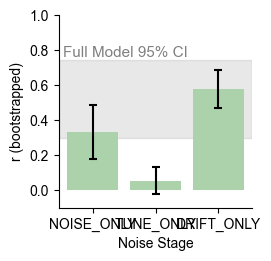

'./figs/model_ablation.pdf'

In [5]:
# Variant order
variant_order = ["FULL", "NOISE_ONLY", "TUNE_ONLY", "DRIFT_ONLY"]

# Choose which group to plot: "ALL" recommended for the overall panel
plot_group = "ALL"
abl_g = abl[abl["Group"].astype(str).str.upper() == plot_group].copy()

abl_g["Variant"] = pd.Categorical(abl_g["Variant"], categories=variant_order, ordered=True)
abl_g = abl_g.sort_values("Variant").reset_index(drop=True)

# Bars: 68% CI
BAR_LO = "r_ci68_lo"   
BAR_HI = "r_ci68_hi"

# FULL band: 95% CI
BAND_LO = "r_ci95_lo"
BAND_HI = "r_ci95_hi"

# Compute asymmetric errors for matplotlib.errorbar (bars)
abl_g["err_lo"] = abl_g["r_mean"] - abl_g[BAR_LO]
abl_g["err_hi"] = abl_g[BAR_HI] - abl_g["r_mean"]

# Pull FULL band values (95%)
row_full = abl_g[abl_g["Variant"] == "FULL"]
if row_full.empty:
    raise ValueError("FULL row not found in the selected group. Check plot_group or CSV export.")

full_mean = float(row_full["r_mean"].iloc[0])
full_lo95 = float(row_full[BAND_LO].iloc[0])
full_hi95 = float(row_full[BAND_HI].iloc[0])

# Plot bars 
plot_variants = ["NOISE_ONLY", "TUNE_ONLY", "DRIFT_ONLY"]  # exclude FULL

dfp = abl_g[abl_g["Variant"].isin(plot_variants)].copy()
dfp = dfp.set_index("Variant").reindex(plot_variants).reset_index()

fig, ax = plt.subplots(figsize=(2.5, 2.5))

# FULL 95% CI band (behind)
ax.axhspan(full_lo95, full_hi95, alpha=0.18, color="gray", zorder=0)

sns.barplot(
    data=dfp,
    x="Variant",
    y="r_mean",
    order=plot_variants,
    color=(0.65, 0.85, 0.65),
    errorbar=None,
    edgecolor="none",
    ax=ax
)

# errorbars
xpos = np.arange(len(plot_variants))  # 0,1,2,...
y = dfp["r_mean"].to_numpy()
yerr = np.vstack([dfp["err_lo"].to_numpy(), dfp["err_hi"].to_numpy()])  # shape (2, n)

ax.errorbar(
    xpos, y,
    yerr=yerr,
    fmt="none",
    ecolor="black",
    elinewidth=1.5,
    capsize=3,
    capthick=1.5,
    zorder=10
)

ax.set_xlabel("Noise Stage")
ax.set_ylabel("r (bootstrapped)")
ax.set_ylim(-0.1, 1.0)

ax.text(
    0.02, full_hi95 + 0.02,
    "Full Model 95% CI",
    color="gray",
    fontsize=11,
    transform=ax.get_yaxis_transform()
)

sns.despine()

outpath = os.path.join(OUTDIR, "model_ablation.pdf")
plt.savefig(outpath, dpi=300, transparent=True, bbox_inches="tight")
plt.show()

outpath


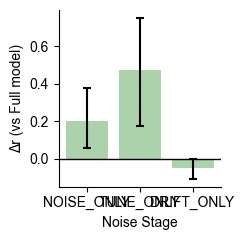

'./figs/model_ablation_paired.pdf'

In [6]:

# choose which group panel to plot 
plot_group = "ALL"
d = abl_paired[abl_paired["Group"].astype(str).str.upper() == plot_group].copy()

# order ablations
order = ["NOISE_ONLY", "TUNE_ONLY", "DRIFT_ONLY"]
d["Ablation"] = pd.Categorical(d["Ablation"], categories=order, ordered=True)
d = d.sort_values("Ablation")

# choose CI level to show
use_ci = "95"  # "68" or "95"
if use_ci == "68":
    lo_col, hi_col = "delta_ci68_lo", "delta_ci68_hi"
else:
    lo_col, hi_col = "delta_ci95_lo", "delta_ci95_hi"

# error lengths for matplotlib.errorbar
d["err_lo"] = d["delta_mean"] - d[lo_col]
d["err_hi"] = d[hi_col] - d["delta_mean"]


fig, ax = plt.subplots(figsize=(2.5, 2.5))

sns.barplot(
    data=d,
    x="Ablation",
    y="delta_mean",
    order=order,
    color=(0.65, 0.85, 0.65),
    errorbar=None,
    edgecolor="none",
    ax=ax
)

# add error bars aligned to bars
for patch, row in zip(ax.patches, d.itertuples(index=False)):
    x = patch.get_x() + patch.get_width()/2
    ax.errorbar(
        x, row.delta_mean,
        yerr=[[row.err_lo], [row.err_hi]],
        fmt="none",
        ecolor="black",
        elinewidth=1.5,
        capsize=3,
        capthick=1.5,
        zorder=10
    )

ax.axhline(0, color="black", linewidth=1)
ax.set_xlabel("Noise Stage")
ax.set_ylabel("Δr (vs Full model)")

sns.despine()
fig.tight_layout()

outpath = os.path.join(OUTDIR, "model_ablation_paired.pdf")
plt.savefig(outpath, dpi=300, transparent=True, bbox_inches="tight")
plt.show()

outpath
